In [ ]:
%matplotlib inline

In [ ]:
!pip install livelossplot

You should consider upgrading via the 'C:\Users\thari\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
# Imports
import numpy as np
import pandas as pd
from glob import glob
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sn

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D, Input, Concatenate
from keras.models import Model, Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3

from livelossplot import PlotLossesKeras

In [ ]:
# Hyperparams
SAMPLE_COUNT = 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 16
BATCH_SIZE = 216
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [ ]:
# Output files
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_FILE = "histopathologic_cancer_detector.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
MODEL_LAYERS_SIMPLIFIED = "model_plot_simplified.png"
MODEL_LAYERS = "model_plot.png"
INPUT_DIR = '../input/histopathologic-cancer-detection/'
training_path = '../training'
validation_path = '../validation'

In [ ]:
import os
# print(os.listdir(INPUT_DIR))

In [ ]:
# Read the train labels and import as DataFrame

training_dir = INPUT_DIR + 'train/'
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split('.')[0])
labels = pd.read_csv(INPUT_DIR + 'train_labels.csv')
data_frame = data_frame.merge(labels, on = 'id')
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]

FileNotFoundError: [Errno 2] No such file or directory: '../input/histopathologic-cancer-detection/train_labels.csv'

In [ ]:
# Create folder for training and validation and sub folders for splitting the data
# as binary classification

for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

In [ ]:
# Split the data according to TRAINING_RATIO  and copy the files to destination folders
training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)

for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(data_frame.loc[image,'label'])
        destination = os.path.join(path, label, file_name)
        if not os.path.exists(destination):
            source = os.path.join(INPUT_DIR + 'train', file_name)
            shutil.copyfile(source, destination)

In [ ]:
# Data Augmentation and Reading the reading the images
# Data generation
training_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=90,
                                             zoom_range=0.2,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.05,
                                             channel_shift_range=0.1).flow_from_directory(training_path,
                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                         batch_size=BATCH_SIZE,
                                         class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')

Found 153000 images belonging to 2 classes.
Found 17000 images belonging to 2 classes.


In [ ]:
# Defining the layers of CNN
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = Sequential()
model.add(Input(input_shape))
model.add(InceptionV3(include_top=False, input_shape=input_shape))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001, decay=0.0001,beta_1=0.9,epsilon=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


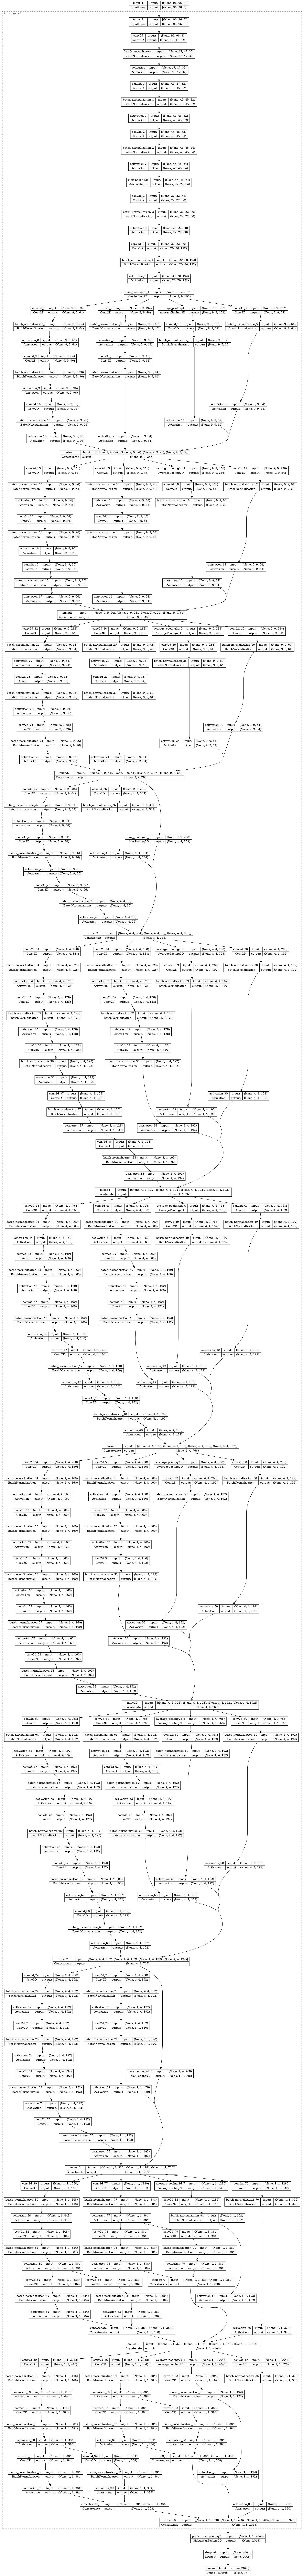

In [ ]:
# Plot the model layer and save it as a file
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.vis_utils import plot_model
plot_model(model, to_file=MODEL_LAYERS_SIMPLIFIED, show_shapes=True, show_layer_names=True, expand_nested=False)
plot_model(model, to_file=MODEL_LAYERS, show_shapes=True, show_layer_names=True, expand_nested=True)

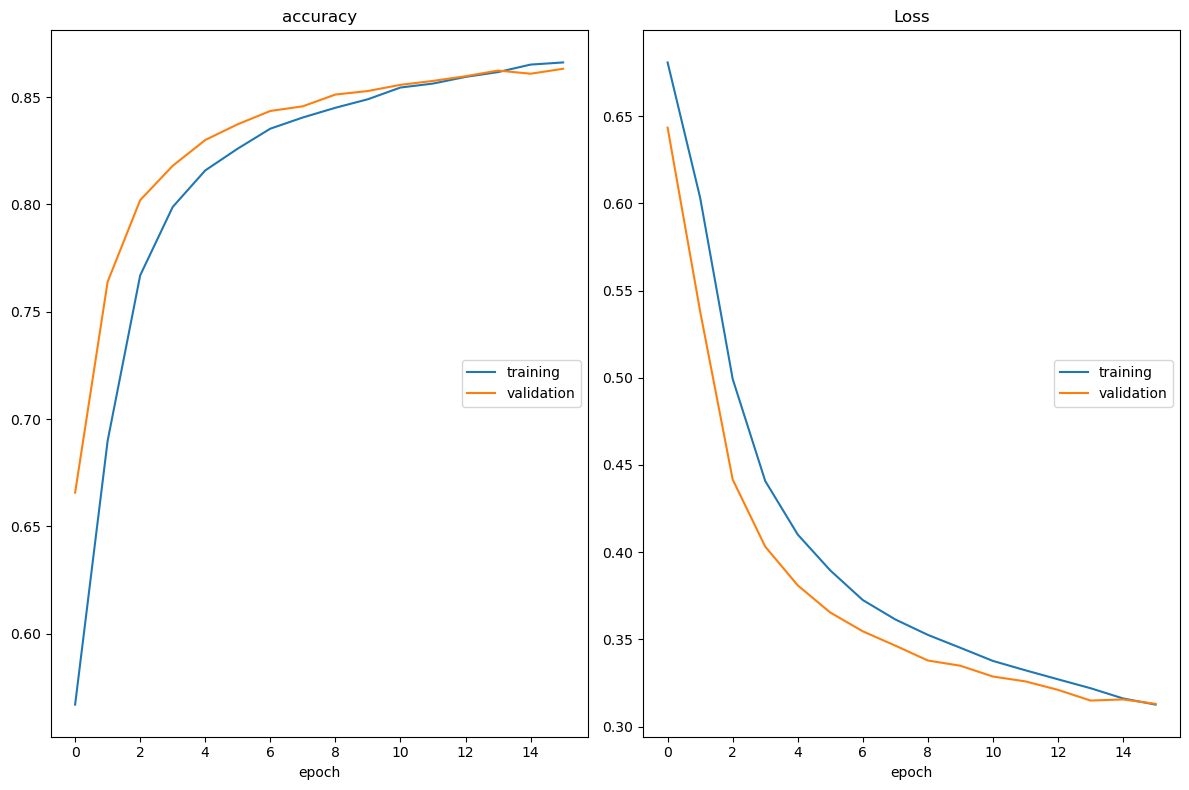

accuracy
	training         	 (min:    0.567, max:    0.866, cur:    0.866)
	validation       	 (min:    0.666, max:    0.863, cur:    0.863)
Loss
	training         	 (min:    0.313, max:    0.681, cur:    0.313)
	validation       	 (min:    0.313, max:    0.643, cur:    0.313)
709/709 [==============================] - 530s 748ms/step - loss: 0.3127 - accuracy: 0.8661 - val_loss: 0.3131 - val_accuracy: 0.8632


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'histopathologic_cancer_detector.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Model Training
history = model.fit(training_generator,
                              steps_per_epoch=len(training_generator),
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[PlotLossesKeras(),
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_accuracy',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=';')])
# Three callbacks
# 1) Plot accuracy and loss graph live
# 2) Save the best model every epoch
# 3) Log the accuracy and loss for each epoch

In [ ]:
model.save(MODEL_FILE)

In [ ]:
# Load the weights from training
model.load_weights(MODEL_FILE)

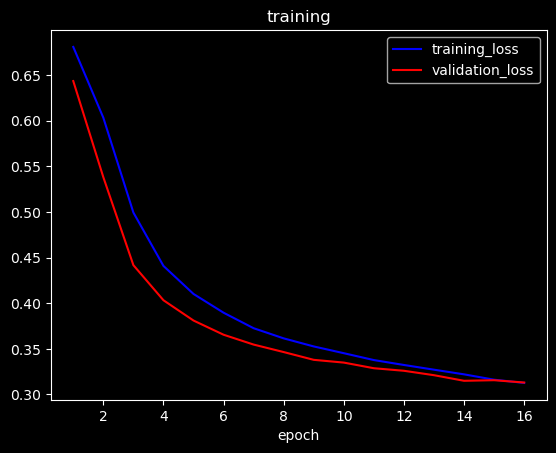

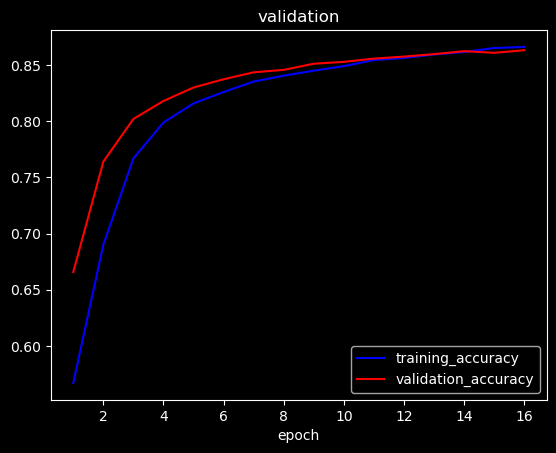

In [ ]:
# Plot training, validation accuracy and loss vs epoch
epochs = [i for i in range(1, len(history.history['loss'])+1)]
plt.style.use('dark_background')

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.show()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()

Found 17000 images belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


79/79 [==============================] - 17s 194ms/step


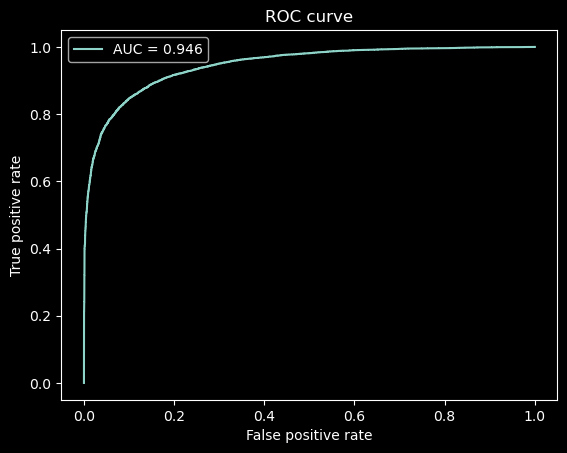

In [ ]:
# Plot ROC validation curse from validation data
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                                  batch_size=BATCH_SIZE,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

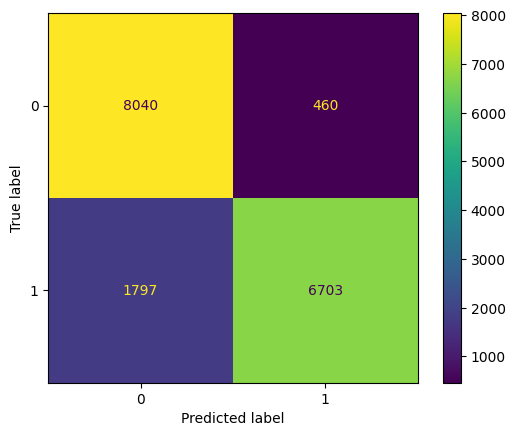

In [ ]:
y_act = roc_validation_generator.classes
y_pred = [1 if i > 0.5 else 0 for i in predictions]
class_labels = list(roc_validation_generator.class_indices.keys())
cm=confusion_matrix(y_true=y_act, y_pred=y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

<Axes: >

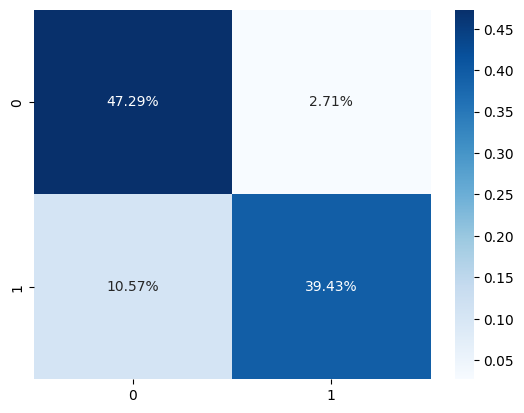

In [ ]:
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_act, y_pred,target_names=class_labels))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      8500
           1       0.94      0.79      0.86      8500

    accuracy                           0.87     17000
   macro avg       0.88      0.87      0.87     17000
weighted avg       0.88      0.87      0.87     17000



In [ ]:
import os
os.chdir(r'/kaggle/working')
print(os.listdir())
from IPython.display import FileLink
FileLink(TRAINING_LOGS_FILE)
FileLink(MODEL_FILE)
FileLink(TRAINING_PLOT_FILE)
FileLink(VALIDATION_PLOT_FILE)
FileLink(ROC_PLOT_FILE)
FileLink(MODEL_LAYERS_SIMPLIFIED)
FileLink(MODEL_LAYERS)

['training.png', 'model_plot_simplified.png', '.virtual_documents', 'training_logs.csv', 'histopathologic_cancer_detector.h5', '__notebook_source__.ipynb', 'validation.png', 'state.db', 'roc.png', 'model_plot.png']


/kaggle/working/training_logs.csv